# preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

import torch
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

# from utils.const import *
# from utils.helperFunctions import *
# from utils.models import *

In [2]:
import torch



# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path of the model (saved/to save)
modelFolder = './models/'

# When True, retrain the whole model
retrain = True

# Downsample the dataset
ds = True

# Specify number of seconds for the window. Default: 16
window_size = 16

# Model hyper-parameters
batch_size = 4
learning_rate = 1e-3

# Seed for reproducibility
seed = 151836

# Classes to drop in the dataset
classes_to_drop=[
    'stabf','stab']



In [3]:
import numpy as np
import os
import pandas as pd
import random

from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from sklearn.metrics import f1_score
from torch.utils.data import Dataset

import torch
import torch.nn as nn



def setSeed(seed=seed):
    """
    Setting the seed for reproducibility
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

setSeed()

def min_max_norm(self,col):
    self._data[col]=(self._data[col]-self._data[col].min())/(self._data[col].max()-self._data[col].min())


def std_scaler(self,col):
    self._data[col]=(self._data[col]-self._data[col].mean())/(self._data[col].std())


def f1(test_loader, model):
    f1 = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            outputs = model(data)
            pred = outputs.data.max(1, keepdim=True)[1]
            f1 += f1_score(labels, pred, average='macro')
    avg_f1 = f1/len(test_loader)
    return (avg_f1)


class CustomDataset(Dataset):
    def __init__(self, file_path='/kaggle/working/new_dataset.csv', classes_to_drop=classes_to_drop, window_size=window_size, normalize=True, normalize_method='mean_std', auth=False, target=None):

        self._window_size=window_size
        self._data=pd.read_csv(file_path)

        # if auth==True:
        #     if target != 'J':
        #         self._data = self._data[self._data['stabf'].isin([target, 'J'])]
        #     else:
        #         self._data = self._data[self._data['stabf'].isin([target, 'I'])]

        #     self._data['stabf'] = self._data['stabf'].apply(lambda x: target if x == target else 'Z')
        #     self._data['stabf'] = self._data['stabf'].map({target: 1, 'Z': 0}).fillna(0).astype(int)


        # # Random Undersampling
        # X = self._data.drop('stabf', axis=1)
        # y = self._data['stabf']

        # # sampler = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)
        # # X_resampled, y_resampled = sampler.fit_resample(X, y)

        # # X_resampled['Class'] = y_resampled
        # self._data = X

        # The data is sorted by Class A,B,C the indexes of the dataframe have restarted by ignore index
        self._data = self._data.sort_values(by=['stabf'], inplace=False,ignore_index = True)

        # class_uniq contains the letters of the drivers A,B and it loops across all of them
        for class_uniq in list(self._data['stabf'].unique()):
            # Find the total number of elements belonging to a class
            tot_number=sum(self._data['stabf']==class_uniq)
            # Number of elements to drop so that the class element is divisible by window size
            to_drop=tot_number%window_size
            # Returns the index of the first element of the class
            index_to_start_removing=self._data[self._data['stabf']==class_uniq].index[0]
            # Drop element from first element to the element required
            self._data.drop(self._data.index[index_to_start_removing:index_to_start_removing+to_drop],inplace=True)


        # Resetting index of dataframe after dropping values
        self._data = self._data.reset_index()
        self._data = self._data.drop(['index'], axis=1)

        index_starting_class=[] # This array contains the starting index of each class in the df
        for class_uniq in list(self._data['stabf'].unique()):
            # Appending the index of first element of each clas
            index_starting_class.append(self._data[self._data['stabf']==class_uniq].index[0])

        # Create the sequence of indexs of the windows
        sequences=[]
        for i in range(len(index_starting_class)):
            # Check if beginning of next class is there
            if i!=len(index_starting_class)-1:
                ranges=np.arange(index_starting_class[i], index_starting_class[i+1])
            else:
                ranges = np.arange(index_starting_class[i], len(self._data))
            for j in range(0,len(ranges),int(self._window_size/2)):
                if len(ranges[j:j+self._window_size])==16:
                    sequences.append(ranges[j:j+self._window_size])
        self._sequences=sequences


        # Take only the 'Class' which are the actual labels and store it in the labels of self
        self._labels=self._data['stabf']
        # Dropping columns which have constant measurements because they would return nan in std
        self._data.drop(classes_to_drop, inplace=True, axis=1)

        # Function to normalize the data either with min_max or mean_std
        if normalize and not auth:
            for col in self._data.columns:
                if normalize_method=='min_max':
                    min_max_norm(self,col)
                elif normalize_method=="mean_std":
                    std_scaler(self,col)

        # Create the array holding the windowed multidimensional arrays
        X=np.empty((len(sequences), self._window_size, len(self._data.columns)))
        y=[]

        for n_row, sequence in enumerate(sequences):
            X[n_row,:,:]=self._data.iloc[sequence]
            # The corresponding driver of the sequence is the driver at first sequence
            y.append(self._labels[sequence[0]])

        assert len(y)==len(X)
        # Assign the windowed dataset to the X of self
        self._X= X

        # Targets is a transformed version of y with drivers are encoded into 0 to 9
        # targets = preprocessing.LabelEncoder().fit_transform(y)
        # class_labels = encoder.classes_
        # for code, label in enumerate(class_labels):
        #   print(f'Code: {code} -> Label: {label}')
        # targets = torch.as_tensor(targets)  # Just converting it to a pytorch tensor
        self._y=y # Assign it to y of self


    def __len__(self):
        return len(self._X)


    def __getitem__(self, index):
        return torch.FloatTensor(self._X[index,:,:]), self._y[index]


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    y_true = []
    y_pred = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs
        labels = labels

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Collect predictions and true labels
        y_true += labels.data.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

    # Calculate accuracy and loss
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_acc, epoch_f1


def evaluateBinary(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    y_true = []
    y_pred = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            # loss = criterion(outputs, labels)
            loss = criterion(outputs.squeeze(), labels.float())

        _, preds = torch.max(outputs, 1)
        # preds = (outputs > 0.5).float()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Collect predictions and true labels
        y_true += labels.data.cpu().numpy().tolist()
        y_pred += preds.cpu().numpy().tolist()

    # Calculate accuracy and loss
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    epoch_f1 = f1_score(y_true, y_pred, average='macro')

    return epoch_loss, epoch_acc, epoch_f1



In [4]:
class Generator(nn.Module):
    def __init__(self, batch_size, window_size, num_features,):
        super(Generator, self).__init__()
        self.batch_size = batch_size
        self.num_features = num_features
        self.window_size = window_size
        self.layer1 = nn.Linear(num_features, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, batch_size*window_size)
        self.layer5 = nn.Linear(batch_size*window_size, num_features)

        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.leaky_relu(self.layer2(x))
        x = self.leaky_relu(self.layer3(x))
        x = self.leaky_relu(self.layer4(x))
        x = self.layer5(x)
        return x

In [5]:
dataset_path = '/kaggle/input/smart-gid-stability/smart_grid_stability_augmented.csv'
df = pd.read_csv(dataset_path)
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


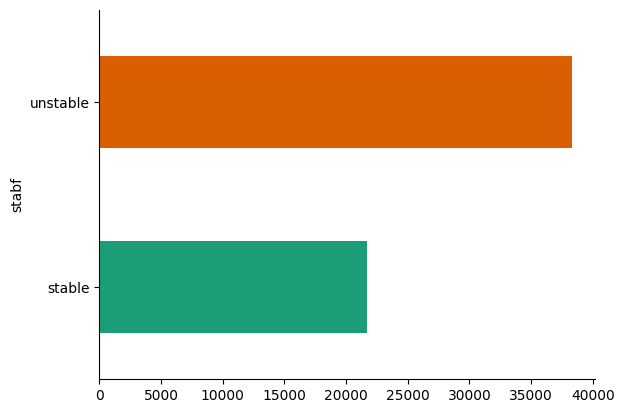

In [6]:
# @title stabf

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('stabf').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['stabf'] = encoder.fit_transform(df['stabf'])

# Retrieve the mapping of numerical codes to original class labels
class_labels = encoder.classes_

# Display the mapping
for code, label in enumerate(class_labels):
    print(f'Code: {code} -> Label: {label}')
df

Code: 0 -> Label: stable
Code: 1 -> Label: unstable


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [8]:
#  Create a new DataFrame containing only rows with value 0
new_df = df[df['stabf'] == 0]

# Display the new DataFrame
new_df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
5,6.999209,9.109247,3.784066,4.267788,4.429669,-1.857139,-0.670397,-1.902133,0.261793,0.077930,0.542884,0.469931,-0.017385,0
8,4.689852,4.007747,1.478573,3.733787,4.041300,-1.410344,-1.238204,-1.392751,0.269708,0.250364,0.164941,0.482439,-0.038677,0
10,5.930110,6.730873,6.245138,0.533288,2.327092,-0.702501,-1.116920,-0.507671,0.239816,0.563110,0.164461,0.753701,-0.028411,0
12,1.616787,2.939228,0.819791,4.191804,3.752282,-1.484885,-1.280581,-0.986816,0.899698,0.866546,0.303921,0.077610,-0.048617,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59980,4.141337,8.400888,1.112868,1.869624,3.671563,-1.513896,-0.699052,-1.458615,0.081811,0.662959,0.094963,0.169682,-0.032192,0
59983,1.482214,5.220920,3.121273,1.609288,4.394557,-0.881996,-1.924542,-1.588019,0.097309,0.383334,0.096599,0.988509,-0.054541,0
59984,2.501787,7.493896,3.087194,2.177944,3.817471,-1.044281,-0.958986,-1.814205,0.503049,0.534358,0.107808,0.357840,-0.036061,0
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0


In [9]:
new_df.to_csv('new_dataset.csv', index=False)
new_df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
5,6.999209,9.109247,3.784066,4.267788,4.429669,-1.857139,-0.670397,-1.902133,0.261793,0.077930,0.542884,0.469931,-0.017385,0
8,4.689852,4.007747,1.478573,3.733787,4.041300,-1.410344,-1.238204,-1.392751,0.269708,0.250364,0.164941,0.482439,-0.038677,0
10,5.930110,6.730873,6.245138,0.533288,2.327092,-0.702501,-1.116920,-0.507671,0.239816,0.563110,0.164461,0.753701,-0.028411,0
12,1.616787,2.939228,0.819791,4.191804,3.752282,-1.484885,-1.280581,-0.986816,0.899698,0.866546,0.303921,0.077610,-0.048617,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59980,4.141337,8.400888,1.112868,1.869624,3.671563,-1.513896,-0.699052,-1.458615,0.081811,0.662959,0.094963,0.169682,-0.032192,0
59983,1.482214,5.220920,3.121273,1.609288,4.394557,-0.881996,-1.924542,-1.588019,0.097309,0.383334,0.096599,0.988509,-0.054541,0
59984,2.501787,7.493896,3.087194,2.177944,3.817471,-1.044281,-0.958986,-1.814205,0.503049,0.534358,0.107808,0.357840,-0.036061,0
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0


In [10]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [11]:
trainSize = 0.9
# valSize = 0.05
a = CustomDataset()

# Defining sizes
train_size = int(trainSize * len(a))
test_size = len(a)-train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    a, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4,
                                          shuffle=False)

In [12]:
for i, (inputs,Labels) in enumerate(train_loader):
  Labels = Labels.to(device)
  print(Labels)

tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0,

In [13]:
!pip install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-be

# GAN-based stability prediction augemnted with novel adverserial training layer

In [15]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


Epoch [0/250], Step [0/610], Discriminator Loss: 1.3853, Generator Loss: 0.9422
Epoch [0/250], Step [10/610], Discriminator Loss: 1.1779, Generator Loss: 0.9885
Epoch [0/250], Step [20/610], Discriminator Loss: 0.6854, Generator Loss: 1.2027
Epoch [0/250], Step [30/610], Discriminator Loss: 0.2554, Generator Loss: 1.9766
Epoch [0/250], Step [40/610], Discriminator Loss: 0.0527, Generator Loss: 3.6937
Epoch [0/250], Step [50/610], Discriminator Loss: 0.0304, Generator Loss: 5.0691
Epoch [0/250], Step [60/610], Discriminator Loss: 0.0338, Generator Loss: 6.0101
Epoch [0/250], Step [70/610], Discriminator Loss: 0.0094, Generator Loss: 5.8430
Epoch [0/250], Step [80/610], Discriminator Loss: 0.0031, Generator Loss: 7.4708
Epoch [0/250], Step [90/610], Discriminator Loss: 0.0051, Generator Loss: 7.9691
Epoch [0/250], Step [100/610], Discriminator Loss: 0.0359, Generator Loss: 9.0854
Epoch [0/250], Step [110/610], Discriminator Loss: 0.1224, Generator Loss: 10.0051
Epoch [0/250], Step [120/6

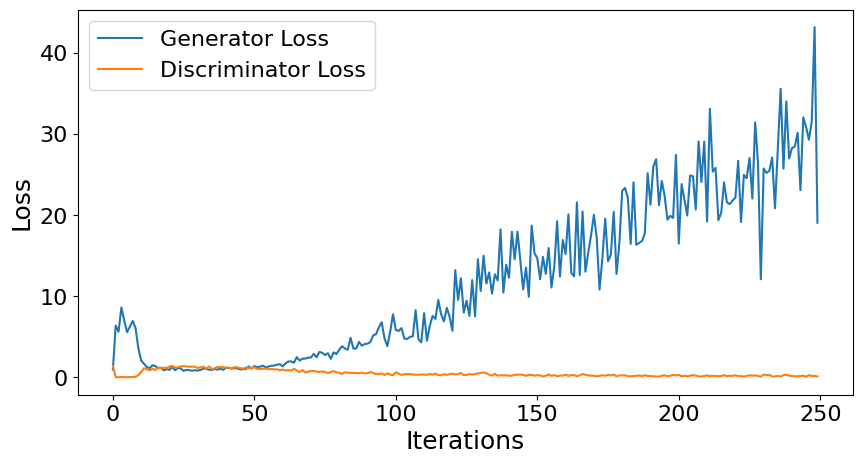

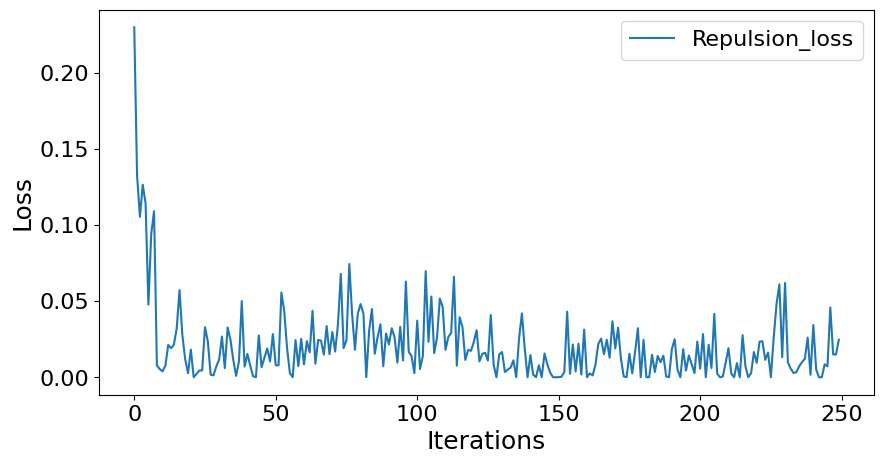

In [16]:
import torchattacks
# Define the generator and discriminator for the GAN
class Generator(nn.Module):
    def __init__(self, batch_size,window_size,num_features,latent_dim=100):
        super(Generator, self).__init__()
        self.batch_size = batch_size
        self.num_features = num_features
        self.window_size = window_size
       # self.fc1 = nn.Linear(latent_dim, 128)
        self.fc1 = nn.Linear(num_features, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 128)
        self.fc3 = nn.Linear(128,batch_size*window_size)
        self.fc4 = nn.Linear(batch_size*window_size,num_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc4(x)
        #return x.view(x.size(0), 1, -1)
        return x

class Discriminator(nn.Module):
    def __init__(self, batch_size, window_size, num_features):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(num_features, 160)
        self.fc2 = nn.Linear(160, 200)
        self.fc3 = nn.Linear(200, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 1)
        self.window_size = window_size
        self.num_features = num_features
        self.batch_size = batch_size

    def forward(self, x):
      #x = x.view(-1, self.num_features)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x



# Define the GAN training function

def train_gan(generator, discriminator, train_loader, num_epochs=100, lr=0.0002,
              device=torch.device('cpu')):

    generator.to(device)
    discriminator.to(device)

    # Define the loss functions and optimizers

    adversarial_loss = nn.BCELoss()
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

    # Initialize lists to store losses
    generator_losses = []
    discriminator_losses = []
    repulsion_losses= []
    epoch_generator_losses=[]
    epoch_repulsion_losses=[]
    epoch_discriminator_losses=[]
    
    for epoch in range(num_epochs):
        for i, (inputs,Labels) in enumerate(train_loader):
            # Move data to device
            inputs = inputs.to(device)
            Labels = Labels.to(device)

            # Train discriminator on real data
            discriminator_optimizer.zero_grad()
            # real_labels = torch.ones(inputs.size(0), inputs.size(1), 1).to(device)
            real_labels = torch.zeros(inputs.size(0), inputs.size(1), 1).to(device)
            real_outputs = discriminator(inputs)
            discriminator_loss_real = adversarial_loss(real_outputs, real_labels)
            discriminator_loss_real.backward()

            # Train discriminator on fake data generated by the generator
            generator_optimizer.zero_grad()
            latent_inputs = torch.randn(inputs.shape[0], inputs.shape[1], inputs.shape[2]).to(device)
            fake_inputs = generator(latent_inputs)
            # fake_labels = torch.zeros(inputs.size(0), inputs.size(1), 1).to(device)
            fake_labels = torch.ones(inputs.size(0), inputs.size(1), 1).to(device)
            fake_outputs = discriminator(fake_inputs)
            discriminator_loss_fake = adversarial_loss(fake_outputs, fake_labels)
            discriminator_loss_fake.backward()
            discriminator_optimizer.step()


            attack_fgsm = torchattacks.FGSM(discriminator, eps=0.05)
            adversarial_inputs_fgsm = attack_fgsm(inputs, torch.zeros_like(real_labels))
            adversarial_outputs_fgsm = discriminator(adversarial_inputs_fgsm.detach())
            adversarial_labels_fgsm = torch.ones(inputs.size(0), inputs.size(1), 1).to(device)
            discriminator_loss_fgsm = adversarial_loss(adversarial_outputs_fgsm, adversarial_labels_fgsm)
            discriminator_loss_fgsm.backward()
            discriminator_optimizer.step()

            # attack_fgsm = torchattacks.FGSM(discriminator, eps=0.05)
            # adversarial_inputs_fgsm = attack_fgsm(inputs, torch.ones_like(real_labels))
            # attack_bim = torchattacks.BIM(discriminator, eps=0.05)
            # adversarial_inputs_bim = attack_bim(inputs, torch.ones_like(real_labels))
            # adversarial_inputs_combined = torch.cat([adversarial_inputs_fgsm, adversarial_inputs_bim], dim=0)
            # fake_labels = torch.zeros(adversarial_inputs_combined.size(0), adversarial_inputs_combined.size(1), 1).to(device)
            # fake_outputs = discriminator(adversarial_inputs_combined)
            # discriminator_loss_fake = adversarial_loss(fake_outputs, fake_labels)
            # discriminator_loss_fake.backward()
            # discriminator_optimizer.step()

            # Train generator to generate samples that increase the discriminator loss
            generator_optimizer.zero_grad()
            latent_inputs = torch.randn(inputs.shape[0], inputs.shape[1], inputs.shape[2]).to(device)
            fake_inputs = generator(latent_inputs)
            # @S: generator wants to maximize the probability of the discriminator being wrong. So loss is computed between discriminator's output to a fake image and the
            #fake label (if the fake label is 0)
            # fake_labels = torch.zeros(inputs.size(0), inputs.size(1), 1).to(device)
            fake_labels = torch.ones(inputs.size(0), inputs.size(1), 1).to(device)
                        # Compute repulsion from stable class
            margin = 4.0  # Desired minimum distance
            lambda_wasserstein= 1.0
            repulsion_loss = torch.mean(torch.relu(margin - torch.norm(fake_inputs - inputs, dim=1)))
            # Penalize closeness to stable inputs
            # Generator loss with repulsion from stable class
            generator_loss = adversarial_loss(discriminator(fake_inputs), real_labels) + \
                             lambda_wasserstein * repulsion_loss
            generator_loss.backward()
            generator_optimizer.step()
            # Store losses
            generator_losses.append(generator_loss.item())
            discriminator_losses.append(discriminator_loss_real.item() + discriminator_loss_fake.item())
            repulsion_losses.append(repulsion_loss.item())
            if i % len(train_loader) == 0:
                epoch_generator_losses.append(generator_loss.item())
                epoch_discriminator_losses.append(discriminator_loss_real.item() + discriminator_loss_fake.item())
                epoch_repulsion_losses.append(repulsion_loss.item())

            if i % 10 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'
                      .format(epoch, num_epochs, i, len(train_loader),
discriminator_loss_real.item() + discriminator_loss_fake.item(), generator_loss.item()))
                # Return the trained generator
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_generator_losses, label='Generator Loss')
    plt.plot(epoch_discriminator_losses, label='Discriminator Loss')
    plt.xlabel('Iterations',fontsize=18)
    plt.ylabel('Loss',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)  # Adjust tick label font size
    plt.legend(fontsize=16)
    # plt.title('Generator and Discriminator Losses',fontsize=20)
    plt.savefig('/kaggle/working/plot1.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_repulsion_losses, label='Repulsion_loss')
    plt.xlabel('Iterations',fontsize=18)
    plt.ylabel('Loss',fontsize=18)
    plt.legend(fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)  # Adjust tick label font size
    # plt.title('Repulsion loss',fontsize=20)
    plt.savefig('/kaggle/working/plot2.png', dpi=300)
    plt.show()
    return generator,discriminator


# Define the number of epochs and learning rate for training the GAN
num_epochs = 250
lr = 0.0002
inputs, classes = next(iter(train_loader))
# Create the GAN models
batch_size, window_size, num_features = inputs.shape
generator = Generator(batch_size,window_size,num_features)
discriminator = Discriminator(batch_size, window_size, num_features)

# Train the GAN on your data
trained_generator_new,trained_discriminator = train_gan(generator, discriminator, train_loader, num_epochs=num_epochs, lr=lr)

In [ ]:
# Load the saved state dictionaries
trained_generator_new.load_state_dict(torch.load('/content/trained_generator_Grid_FGSM (4).pth'))
trained_discriminator.load_state_dict(torch.load('/content/trained_discriminator_Grid_FGSM (4).pth'))

# Evaluation of stable class

In [18]:
# List to store predicted class labels
predicted_labels = []

# Set the discriminator to evaluation mode
trained_discriminator.eval()

with torch.no_grad():
    for inputs, _ in test_loader:

        # Get the discriminator's output for the current batch
        inputs = inputs.to(device)
        surrogate_outputs = trained_discriminator(inputs)

        # Apply thresholding to determine class labels
        threshold = 0.5
        batch_predicted_labels = (surrogate_outputs >= threshold).int()  # 1 if >= threshold, 0 otherwise
        predicted_labels.append(batch_predicted_labels)

# Convert the list of predicted labels to a single tensor
predicted_labels = torch.cat(predicted_labels, dim=0)

# Print the predicted labels
print(predicted_labels)


tensor([[[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]], dtype=torch.int32)


In [19]:
# True labels (all 1)
true_labels = torch.zeros_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 91.29%


# Evaluation of unstable class

In [20]:
#  Create a new DataFrame containing only rows with value 0 in 'column_name'
new_df = df[df['stabf'] == 1]

# Display the new DataFrame
new_df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
6,6.710166,3.765204,6.929314,8.818562,2.397419,-0.614590,-1.208826,-0.574004,0.177890,0.397977,0.402046,0.376630,0.005954,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59993,5.754191,5.084803,3.032743,4.633624,5.199250,-1.713212,-1.717030,-1.769009,0.157284,0.511555,0.975921,0.696591,0.050212,1
59994,2.042954,8.173809,8.514335,5.466635,3.783797,-0.662469,-1.639912,-1.481417,0.154129,0.053225,0.944486,0.499109,0.026311,1
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [21]:
new_df.to_csv('new_dataset.csv', index=False)
new_df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
6,6.710166,3.765204,6.929314,8.818562,2.397419,-0.614590,-1.208826,-0.574004,0.177890,0.397977,0.402046,0.376630,0.005954,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59993,5.754191,5.084803,3.032743,4.633624,5.199250,-1.713212,-1.717030,-1.769009,0.157284,0.511555,0.975921,0.696591,0.050212,1
59994,2.042954,8.173809,8.514335,5.466635,3.783797,-0.662469,-1.639912,-1.481417,0.154129,0.053225,0.944486,0.499109,0.026311,1
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [22]:
trainSize = 0.01
# valSize = 0.05
a = CustomDataset()

# Defining sizes
train_size = int(trainSize * len(a))
test_size = len(a)-train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    a, [train_size, test_size])

train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True,
                                           drop_last=True)

test_loader1 = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4,
                                          shuffle=False)

In [23]:
for i, (inputs,Labels) in enumerate(test_loader1):
  Labels = Labels.to(device)
  print(Labels)

tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1,

In [24]:
# List to store predicted class labels
predicted_labels = []

# Set the discriminator to evaluation mode
trained_discriminator.eval()

with torch.no_grad():
    for inputs, _ in test_loader1:

        # Get the discriminator's output for the current batch
        inputs = inputs.to(device)
        surrogate_outputs = trained_discriminator(inputs)

        # Apply thresholding to determine class labels
        threshold = 0.5
        batch_predicted_labels = (surrogate_outputs >= threshold).int()  # 1 if >= threshold, 0 otherwise
        predicted_labels.append(batch_predicted_labels)

# Convert the list of predicted labels to a single tensor
predicted_labels = torch.cat(predicted_labels, dim=0)

# Print the predicted labels
print(predicted_labels)


tensor([[[1],
         [1],
         [1],
         ...,
         [0],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]]], dtype=torch.int32)


In [25]:
# True labels (all 1)
true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")



Accuracy: 97.91%


# Evaluation of Both classes

In [26]:
from sklearn.metrics import accuracy_score, f1_score

# List to store predicted class labels and true labels
predicted_labels = []
true_labels = []

# Set the discriminator to evaluation mode
trained_discriminator.eval()

with torch.no_grad():
    # Loop through the first test loader
    for inputs, labels in test_loader1:
        inputs = inputs.to(device)
        surrogate_outputs = trained_discriminator(inputs)
        threshold = 0.5
        batch_predicted_labels = (surrogate_outputs >= threshold).int()
        predicted_labels.append(batch_predicted_labels.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

    # Loop through the second test loader
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        surrogate_outputs = trained_discriminator(inputs)
        threshold = 0.5
        batch_predicted_labels = (surrogate_outputs >= threshold).int()
        predicted_labels.append(batch_predicted_labels.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

# Convert the list of predicted labels and true labels to numpy arrays
predicted_labels = np.concatenate(predicted_labels)
predicted_labels_selected = predicted_labels[:, 0, 0]
true_labels = np.concatenate(true_labels, axis=0)
# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_labels_selected)
f1 = f1_score(true_labels, predicted_labels_selected)

# Print accuracy and F1 score
print("Accuracy:", accuracy)
print("F1 Score:", f1)


Accuracy: 0.9754392971246006
F1 Score: 0.9868967721316715


# Evalution of the Adverserial attacks(whitebox) being classfied as unstable



In [28]:

# Load the pre-trained model
trained_discriminator.eval()
predicted_labels_fgsm= []
predicted_labels_bim= []
predicted_labels_cw= []
predicted_labels_RFGSM=[]
predicted_labels_PGD=[]
predicted_labels_square=[]

# Attack parameters
epsilon_fgsm = 0.05 # Perturbation magnitude for FGSM
epsilon_bim = 0.05# Perturbation magnitude for BIM
epsilon_cw = 0.05# Perturbation magnitude for C&W
epsilon_square = 0.5

threshold = 0.5
correct_original = 0
correct_adversarial_fgsm = 0
correct_adversarial_bim = 0
correct_adversarial_cw = 0
total = 0

# Iterate over the test set
for inputs, labels in test_loader:
    # Forward pass on the original input
    outputs_original = trained_discriminator(inputs)
    _, predicted_original = torch.max(outputs_original, 1)

    # FGSM: Craft adversarial example
    attack_fgsm = torchattacks.FGSM(trained_discriminator, eps=epsilon_fgsm)
    adversarial_inputs_fgsm = attack_fgsm(inputs, Labels.unsqueeze(1))

    # BIM: Craft adversarial example
    attack_bim = torchattacks.BIM(trained_discriminator, eps=epsilon_bim)
    adversarial_inputs_bim = attack_bim(inputs, Labels.unsqueeze(1))


    attack_RFGSM = torchattacks.RFGSM(trained_discriminator, eps=epsilon_bim)
    adversarial_inputs_RFGSM = attack_RFGSM(inputs, Labels.unsqueeze(1))

    attack_PGD = torchattacks.PGD(trained_discriminator, eps=epsilon_bim)
    adversarial_inputs_PGD = attack_PGD(inputs, Labels.unsqueeze(1))




    # Forward pass on the adversarial inputs
    outputs_adversarial_fgsm = trained_discriminator(adversarial_inputs_fgsm)
    batch_predicted_labels1 = (outputs_adversarial_fgsm >= threshold).int()  # 1 if >= threshold, 0 otherwise
    predicted_labels_fgsm.append(batch_predicted_labels1)
    outputs_adversarial_bim = trained_discriminator(adversarial_inputs_bim)
    batch_predicted_labels2 = (outputs_adversarial_bim >= threshold).int()
    predicted_labels_bim.append(batch_predicted_labels2)
    outputs_adversarial_RFGSM = trained_discriminator(adversarial_inputs_RFGSM)
    batch_predicted_labels4 = (outputs_adversarial_RFGSM >= threshold).int()
    predicted_labels_RFGSM.append(batch_predicted_labels4)
    outputs_adversarial_PGD = trained_discriminator(adversarial_inputs_PGD)
    batch_predicted_labels5 = (outputs_adversarial_PGD >= threshold).int()
    predicted_labels_PGD.append(batch_predicted_labels5)



predicted_labels = torch.cat(predicted_labels_fgsm, dim=0)
predicted_labels1 = torch.cat(predicted_labels_bim, dim=0)
predicted_labels3= torch.cat(predicted_labels_RFGSM, dim=0)
predicted_labels4= torch.cat(predicted_labels_PGD, dim=0)

In [29]:

true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [30]:

true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels1 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 92.46%


In [31]:

true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels3 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [34]:

true_labels = torch.ones_like(predicted_labels)


# Calculate accuracy
correct_predictions = (predicted_labels4 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [35]:

# Load the pre-trained model
trained_discriminator.eval()
predicted_labels_fgsm= []
predicted_labels_bim= []
predicted_labels_cw= []
predicted_labels_RFGSM=[]
predicted_labels_PGD=[]
predicted_labels_square=[]

# Attack parameters
epsilon_fgsm = 0.05 # Perturbation magnitude for FGSM
epsilon_bim = 0.05# Perturbation magnitude for BIM
epsilon_cw = 0.05# Perturbation magnitude for C&W
epsilon_square = 0.5

threshold = 0.5
correct_original = 0
correct_adversarial_fgsm = 0
correct_adversarial_bim = 0
correct_adversarial_cw = 0
total = 0

# Iterate over the test set
for inputs, labels in test_loader1:
    # Forward pass on the original input
    outputs_original = trained_discriminator(inputs)
    _, predicted_original = torch.max(outputs_original, 1)

    # FGSM: Craft adversarial example
    attack_fgsm = torchattacks.FGSM(trained_discriminator, eps=epsilon_fgsm)
    adversarial_inputs_fgsm = attack_fgsm(inputs, Labels.unsqueeze(1))

    # BIM: Craft adversarial example
    attack_bim = torchattacks.BIM(trained_discriminator, eps=epsilon_bim)
    adversarial_inputs_bim = attack_bim(inputs, Labels.unsqueeze(1))



    attack_RFGSM = torchattacks.RFGSM(trained_discriminator, eps=epsilon_bim)
    adversarial_inputs_RFGSM = attack_RFGSM(inputs, Labels.unsqueeze(1))

    attack_PGD = torchattacks.PGD(trained_discriminator, eps=epsilon_bim)
    adversarial_inputs_PGD = attack_PGD(inputs, Labels.unsqueeze(1))




    # Forward pass on the adversarial inputs
    outputs_adversarial_fgsm = trained_discriminator(adversarial_inputs_fgsm)
    batch_predicted_labels1 = (outputs_adversarial_fgsm >= threshold).int()  # 1 if >= threshold, 0 otherwise
    predicted_labels_fgsm.append(batch_predicted_labels1)
    outputs_adversarial_bim = trained_discriminator(adversarial_inputs_bim)
    batch_predicted_labels2 = (outputs_adversarial_bim >= threshold).int()
    predicted_labels_bim.append(batch_predicted_labels2)
    outputs_adversarial_RFGSM = trained_discriminator(adversarial_inputs_RFGSM)
    batch_predicted_labels4 = (outputs_adversarial_RFGSM >= threshold).int()
    predicted_labels_RFGSM.append(batch_predicted_labels4)
    outputs_adversarial_PGD = trained_discriminator(adversarial_inputs_PGD)
    batch_predicted_labels5 = (outputs_adversarial_PGD >= threshold).int()
    predicted_labels_PGD.append(batch_predicted_labels5)



predicted_labels = torch.cat(predicted_labels_fgsm, dim=0)
predicted_labels1 = torch.cat(predicted_labels_bim, dim=0)
predicted_labels3= torch.cat(predicted_labels_RFGSM, dim=0)
predicted_labels4= torch.cat(predicted_labels_PGD, dim=0)


In [36]:

true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [37]:

true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels1 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 99.19%


In [38]:

true_labels = torch.ones_like(predicted_labels)

# Calculate accuracy
correct_predictions = (predicted_labels3 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


In [39]:

true_labels = torch.ones_like(predicted_labels)


# Calculate accuracy
correct_predictions = (predicted_labels4 == true_labels).sum().item()
total_samples = true_labels.numel()  # Total number of elements in the tensor
accuracy = correct_predictions / total_samples * 100

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 100.00%


# Training the surrogate model for Greybox attack

In [47]:
dataset_path = '/kaggle/input/smart-gid-stability/smart_grid_stability_augmented.csv'
df = pd.read_csv(dataset_path)
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


In [48]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
df['stabf'] = encoder.fit_transform(df['stabf'])

# Retrieve the mapping of numerical codes to original class labels
class_labels = encoder.classes_

# Display the mapping
for code, label in enumerate(class_labels):
    print(f'Code: {code} -> Label: {label}')
df

Code: 0 -> Label: stable
Code: 1 -> Label: unstable


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [49]:
df.to_csv('new_dataset.csv', index=False)
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [50]:
a = CustomDataset()
# Size of the split
trainSize = 0.75
valSize = 0.05
testSize = 0.20

# Defining sizes
train_size = int(trainSize * len(a))
val_size = int(valSize * len(a))
test_size = len(a)-train_size-val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    a, [train_size, val_size, test_size])


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           drop_last=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [51]:
import torch.optim as optim

class RNNBinaryClassification(torch.nn.Module):
    def __init__(self, batch_size, window_size, num_features, dropout_rate=0.5):
        super(RNNBinaryClassification, self).__init__()
        self.rnn1 = torch.nn.LSTM(num_features, 220, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(440, 1)  # Output size is 1 for binary classification
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        rnn1_out, _ = self.rnn1(x)
        rnn1_out = self.dropout(rnn1_out[:, -1, :])
        fc_out = self.fc(rnn1_out)
        out = self.sigmoid(fc_out)
        return out
# Initialize your model, criterion, and optimizer
model = RNNBinaryClassification(batch_size, window_size, 12).to(device)
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

retrain = False

if not os.path.exists('./models/rnn_auth.pt') or retrain:
    # Training loop
    for epoch in range(10):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)

        print(f'[💪 EPOCH {epoch+1}/{10}] Loss: {average_loss:.3f}')

[💪 EPOCH 1/10] Loss: 0.040
[💪 EPOCH 2/10] Loss: 0.002
[💪 EPOCH 3/10] Loss: 0.003
[💪 EPOCH 4/10] Loss: 0.007
[💪 EPOCH 5/10] Loss: 0.000
[💪 EPOCH 6/10] Loss: 0.000
[💪 EPOCH 7/10] Loss: 0.004
[💪 EPOCH 8/10] Loss: 0.006
[💪 EPOCH 9/10] Loss: 0.001
[💪 EPOCH 10/10] Loss: 0.000


In [52]:
# Calculate accuracy
correct_predictions = 0
total_samples = 0

y_true = []
y_pred = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    predictions = (outputs > 0.5).float()

    for p, l in zip(predictions, labels.float()):
        if p == l:
            correct_predictions += 1

    total_samples += labels.size(0)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

acc = correct_predictions/total_samples
f1 = f1_score(y_true, y_pred, average='binary')

print('[👑 TEST GRU AUTH]\n')
print(f'[🎯 ACCURACY] {acc:.3f}')
print(f'[⚖️ F1 SCORE] {f1:.3f}')

[👑 TEST GRU AUTH]

[🎯 ACCURACY] 1.000
[⚖️ F1 SCORE] 1.000


# Attacking the surrogate model and testing adverserial exampels (greybox) against GAN-baes stability prediction

In [53]:
pip install adversarial-robustness-toolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [54]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch, ProjectedGradientDescentNumpy, CarliniLInfMethod, CarliniWagnerASR,UniversalPerturbation, DeepFool
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion.iterative_method import BasicIterativeMethod
from sklearn.metrics import accuracy_score, f1_score

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    input_shape=(12,),
    nb_classes=2,
    device_type="cpu"
    # device_type="gpu" if torch.cuda.is_available() else "cpu"
)

# Define FGSM, BIM, and CW attacks
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.05)
bim_attack = BasicIterativeMethod(estimator=classifier, eps=0.05)
pgd_attack = ProjectedGradientDescentNumpy(estimator=classifier, eps=0.05)


def evaluate_clean_data(model, test_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0


    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()

            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    acc = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')

    print('[👑 EVALUATION ON CLEAN DATA]\n')
    print(f'[🎯 ACCURACY] {acc:.3f}')
    print(f'[⚖️ F1 SCORE] {f1:.3f}')


evaluate_clean_data(model, test_loader)




[👑 EVALUATION ON CLEAN DATA]

[🎯 ACCURACY] 1.000
[⚖️ F1 SCORE] 1.000


In [55]:
def evaluate_attack(model, test_loader, attack):
    model.eval()
    y_true = []
    y_pred = []
    correct_predictions1 = 0
    predicted_labels = []
    true_labels=[]

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
        adv_inputs = attack.generate(x=inputs.cpu().numpy())
        adv_inputs = torch.tensor(adv_inputs).to(device)
        outputs = trained_discriminator(adv_inputs)
        predictions = (outputs >= 0.5).int()
        predicted_labels.append(predictions.numpy())
        true_labels.append(labels.numpy())


    # Concatenate the list of predicted labels to a single tensor
    predicted_labels = np.concatenate(predicted_labels)
    predicted_labels_selected = predicted_labels[:, 0, 0]
    true_labels = np.concatenate(true_labels, axis=0)
    true_labels = np.ones_like(true_labels)

    acc = accuracy_score(true_labels, predicted_labels_selected)
    f1 = f1_score(true_labels, predicted_labels_selected)

    print('[👑 EVALUATION UNDER ATTACK]\n')
    print(f'[🎯 ACCURACY] {acc:.3f}')
    print(f'[🎯 F1] {f1:.3f}')


In [56]:
# Evaluate under FGSM attack
evaluate_attack(model, test_loader, fgsm_attack)

[👑 EVALUATION UNDER ATTACK]

[🎯 ACCURACY] 0.954
[🎯 F1] 0.976


In [57]:
# Evaluate under BIM attack
evaluate_attack(model, test_loader, bim_attack)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[👑 EVALUATION UNDER ATTACK]

[🎯 ACCURACY] 0.955
[🎯 F1] 0.977


In [ ]:
# Evaluate under BIM attack
evaluate_attack(model, test_loader, pgd_attack)